In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

import wandb

In [54]:
spectra = pd.read_csv('/home/cmdunham/mass_spec/mass_spec_repo/data/scaled_spectra_with_instrument_type.csv')

Currently going from chemical name to spectrum, since we give Chemception a chemical name to start with. We should maybe compare going from SMILES to spectrum, since Chemception does eventually have that information.

In [32]:
class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.model = nn.Sequential(
      nn.Linear(50,153),
      nn.LeakyReLU(inplace=True),
      nn.Linear(153,256),
      nn.LeakyReLU(inplace=True),
      nn.Linear(256, 359),
      nn.LeakyReLU(inplace=True),
      nn.Linear(359,462),
      nn.LeakyReLU(inplace=True),
      nn.Linear(462,565),
      nn.LeakyReLU(inplace=True),
      nn.Linear(565, 658),
      nn.LeakyReLU(inplace=True),
      nn.Linear(658,761),
      nn.LeakyReLU(inplace=True),
      nn.Linear(761,864),
      nn.LeakyReLU(inplace=True),
      nn.Linear(864, 977),
    )

  def forward(self, x):
    x = self.model(x)
    return x

In [ ]:
def get_weighted_cosine_similarity(output, target):
  # it is common to use m/z ratio as weights since fragments with higher m/z ratios are more important.
  mz = torch.arange(1, len(target)+1)

  numerator = torch.sum(mz*output*target)
  output_denom = torch.sqrt(torch.sum(mz*output**2))
  target_denom = torch.sqrt(torch.sum(mz*target**2))

  weighted_cosine_similarity = numerator/(output_denom*target_denom)
  return(weighted_cosine_similarity)

In [81]:
def plot_results(real_spectra, fake_spectra, labels, idx=[0,10], window=300, cutoff = 0.5):
  """
  Plot and compare real and synthetic spectra within a specified index range.

  Takes in real, noisy, and synthetic spectra and plots them for comparison.
  Computes and prints the weighted cosine similarity between the real spectrum and 
  both the noisy and synthetic spectra.

  Args:
      real_spectra (list of list of float): List of real spectra, where each spectrum is a list of intensity values.
      fake_spectra (list of list of float): List of synthetic spectra generated by decoder.
      labels (list of str): List of chemical name labels corresponding to each spectrum.
      idx (list of int, optional): Range of indices to plot. Default is [0, 10].
      window (int, optional): Highest m/z to plot for each spectrum. Default is 300.
      cutoff (float, optional): Intensity cutoff threshold to filter out low-intensity noise. Default is 0.5.
  """
  for i, (real_spec, fake_spec) in enumerate(zip(real_spectra, fake_spectra)):
    # only plot spectra within the specified index range
    if i > idx[1]:
      break
    if idx[0] <= i < idx[1]:
      # Define the x-axis range
      numbers = range(0, window)
      
      # Scale the real spectrum so highest peak is 100
      input_frequencies = real_spec.copy()
      input_max = max(input_frequencies)
      scaled_input = [num/input_max * 100 for num in input_frequencies]

      # No need to scale noisy spectrum, plot should display what the input to the model looked like

      # Scale the synthetic spectrum so highest peak is 100
      out_clone = fake_spec.copy()
      output_max = max(out_clone)
      scaled_out = [num/output_max * 100 for num in out_clone]
      out_frequencies = [0 if num < cutoff else num for num in scaled_out]

      weighted_cosine_similarity = get_weighted_cosine_similarity(out_clone, input_frequencies)

      # Create a plot with 2 subplots for real and synthetic spectra
      _, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20, 10))

      ax[0].bar(numbers, scaled_input[:window])
      ax[0].set_title(f'True {labels[i]} Spectrum.', fontsize=18)
      ax[0].set_xlabel('Mass to Charge Ratio', fontsize=16)
      ax[0].set_ylabel('Intensity', fontsize=16)

      ax[1].bar(numbers, out_frequencies[:window])
      ax[1].set_title(f'Synthetic {labels[i]} Spectrum.', fontsize=18)
      print('Weighted cosine similarity between true spectrum and output spectrum is: ', round(float(weighted_cosine_similarity), 2))
      ax[1].set_xlabel('Mass to Charge Ratio', fontsize=16)
      ax[1].set_ylabel('Intensity', fontsize=16)

      plt.tight_layout()
      plt.show()

In [75]:
# create list of chemical names that will be input for model
spectra_names = [chem.split('.')[0] for chem in spectra.columns]

# One-hot encode the chemical names
encoder = OneHotEncoder(sparse_output=False)
encoded_names = encoder.fit_transform(pd.DataFrame(spectra_names))

In [76]:
input_data = torch.tensor(encoded_names, dtype=torch.float32)
output = torch.tensor(spectra.values, dtype=torch.float32).T
dataset = TensorDataset(input_data, output)
dataset = DataLoader(dataset=dataset, batch_size=32, shuffle=True)

In [77]:
lr = .01
model = Autoencoder()
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
criterion = nn.MSELoss()

epochs = 300

model_output = []
true_spectra = []
output_labels = []
for epoch in range(epochs):
    epoch_loss = 0
    for batch_x, batch_y in dataset:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(batch_x)
        loss = criterion(output, batch_y)
        epoch_loss += loss

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        if (epoch+1)==epochs:
            chem_names = [spectra_names[list(encoding).index(1)] for encoding in batch_x]
            for output_spectrum, chem_name, true_spectrum in zip(output, chem_names, batch_y):
                model_output.append(output_spectrum)
                output_labels.append(chem_name)
                true_spectra.append(true_spectrum)

    if (epoch+1) % 10 == 0:
        average_loss = epoch_loss/len(dataset)
        print('Epoch[{}/{}], train loss: {}'.format(epoch+1, epochs, round(float(average_loss.detach().numpy()), 6), 6))
    




Epoch[10/300], train loss: 6620.932129
Epoch[20/300], train loss: 287.980255
Epoch[30/300], train loss: 168.276108
Epoch[40/300], train loss: 107.055931
Epoch[50/300], train loss: 73.549858
Epoch[60/300], train loss: 52.117813
Epoch[70/300], train loss: 40.97794
Epoch[80/300], train loss: 33.17215
Epoch[90/300], train loss: 28.30467
Epoch[100/300], train loss: 25.009779
Epoch[110/300], train loss: 22.747978
Epoch[120/300], train loss: 21.144054
Epoch[130/300], train loss: 20.073626
Epoch[140/300], train loss: 19.304405
Epoch[150/300], train loss: 18.713253
Epoch[160/300], train loss: 18.358944
Epoch[170/300], train loss: 18.057638
Epoch[180/300], train loss: 17.825605
Epoch[190/300], train loss: 17.675034
Epoch[200/300], train loss: 17.550688
Epoch[210/300], train loss: 17.497429
Epoch[220/300], train loss: 17.400557
Epoch[230/300], train loss: 17.370251
Epoch[240/300], train loss: 17.319307
Epoch[250/300], train loss: 17.300734
Epoch[260/300], train loss: 17.287863
Epoch[270/300], tra

Weighted cosine similarity between true spectrum and output spectrum is:  0.39


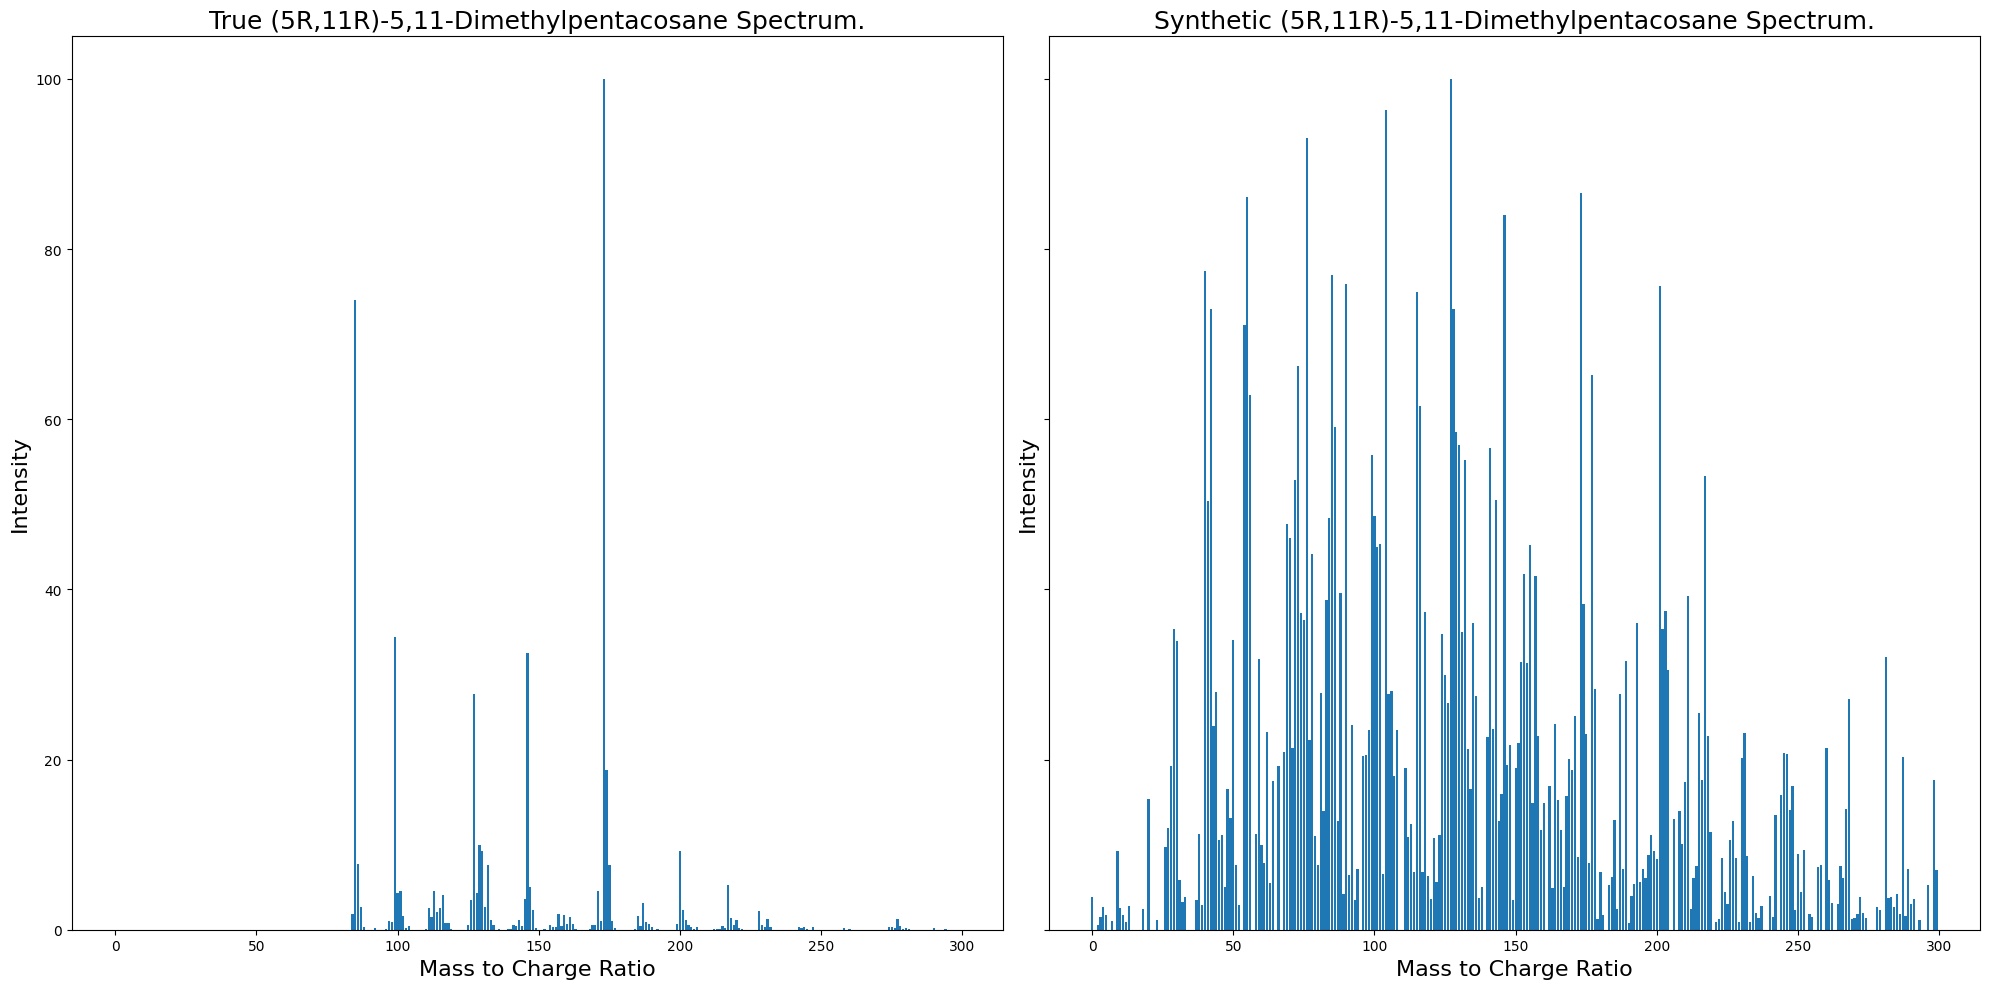

Weighted cosine similarity between true spectrum and output spectrum is:  0.38


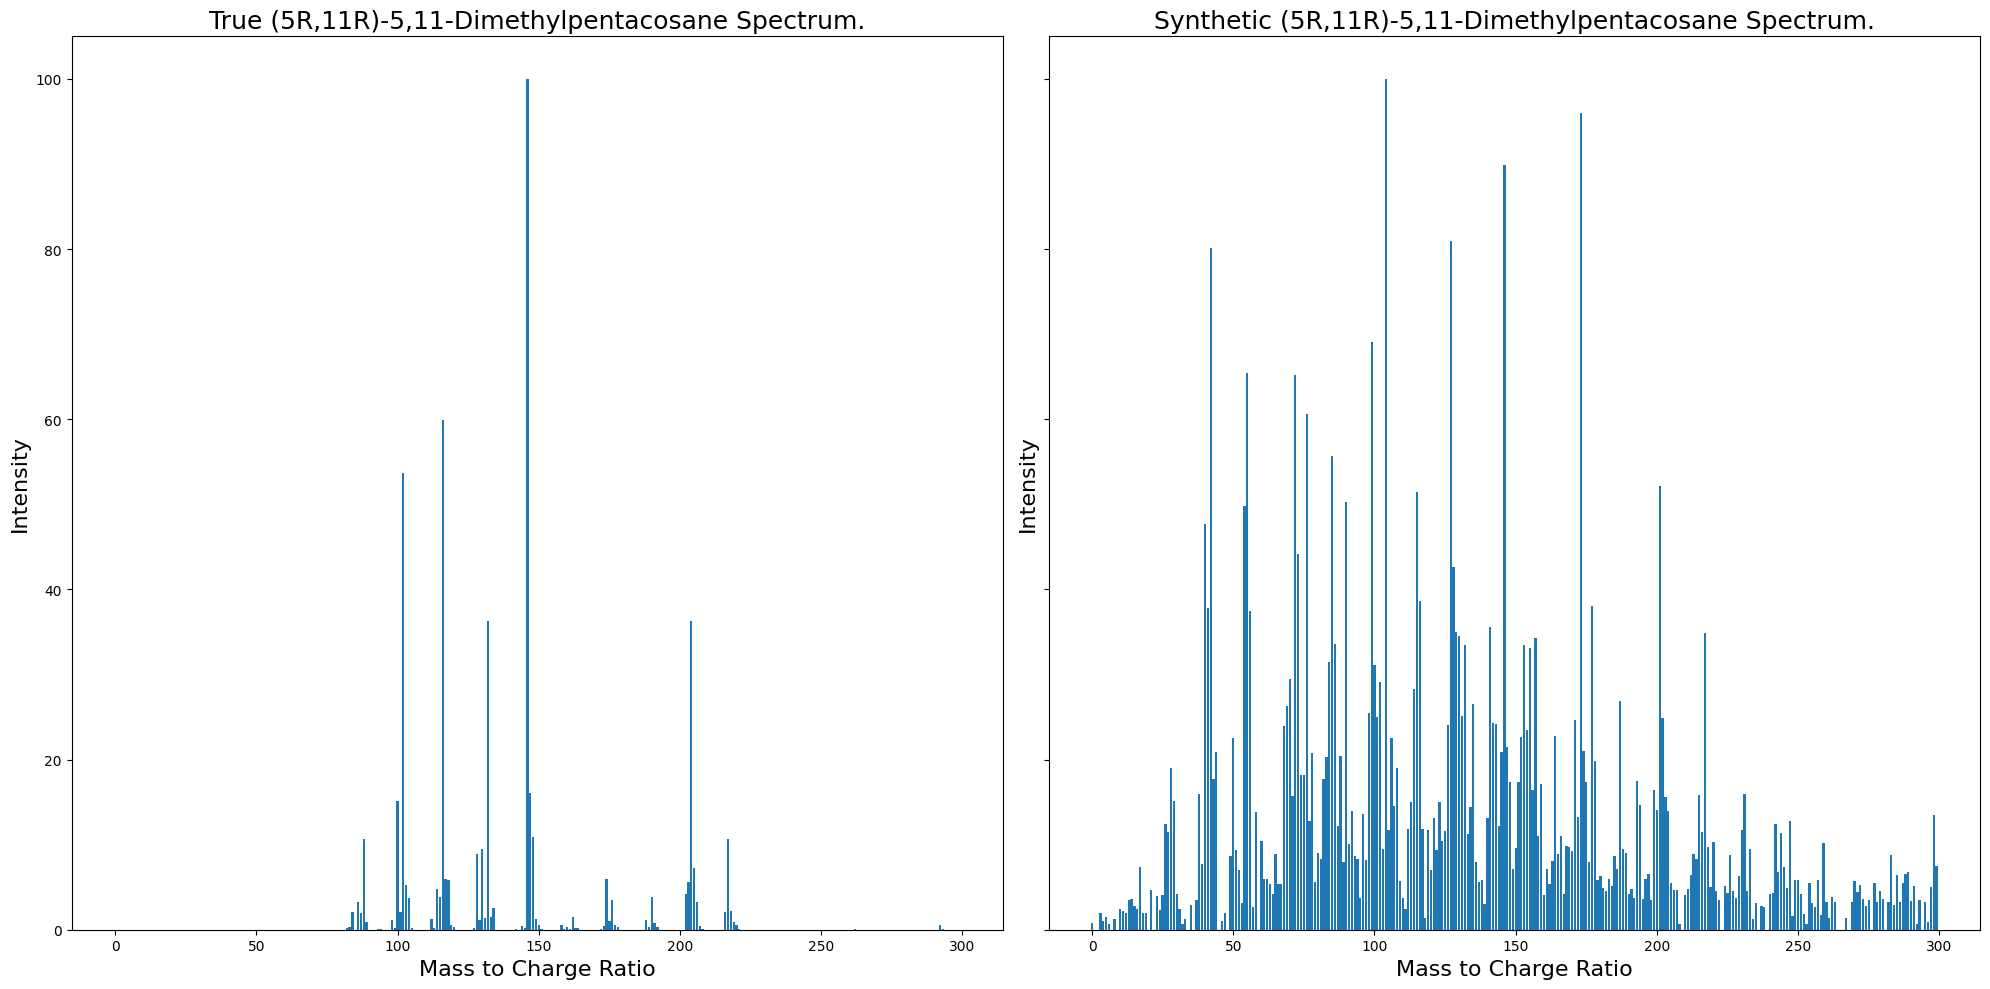

Weighted cosine similarity between true spectrum and output spectrum is:  0.31


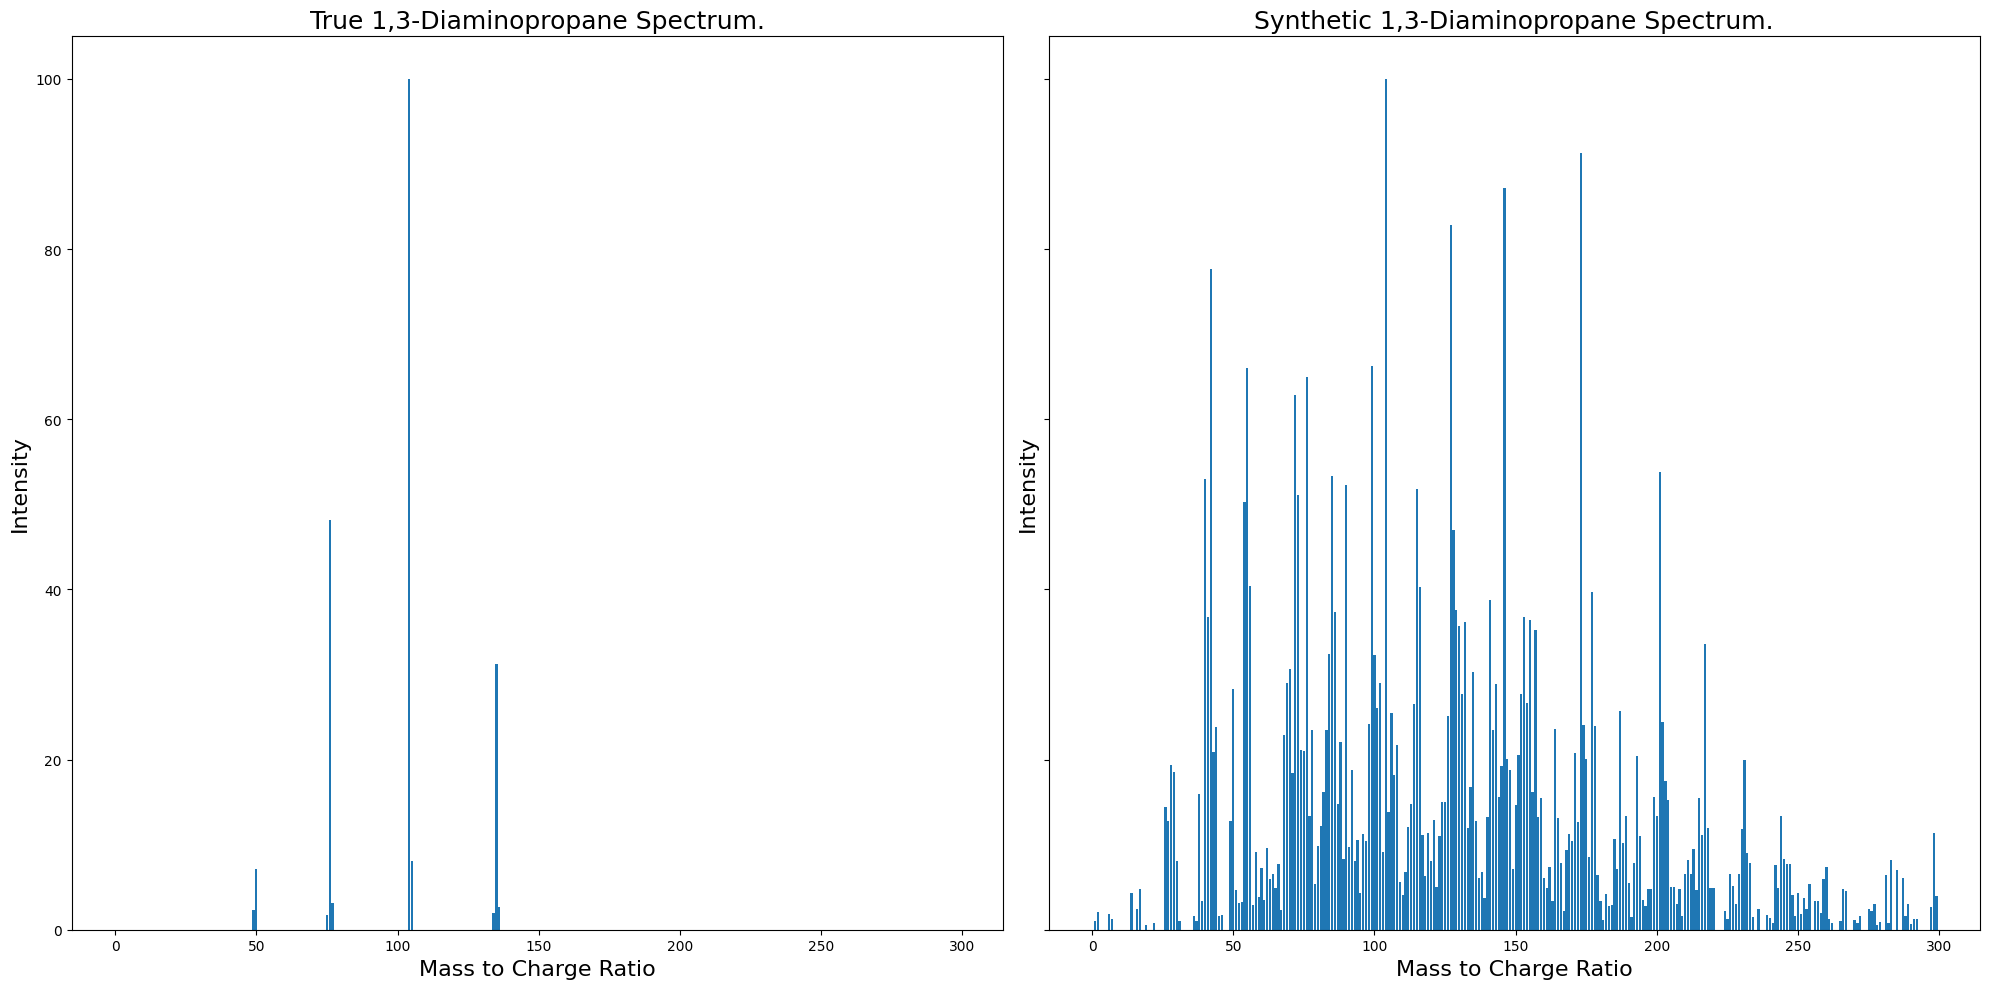

Weighted cosine similarity between true spectrum and output spectrum is:  0.19


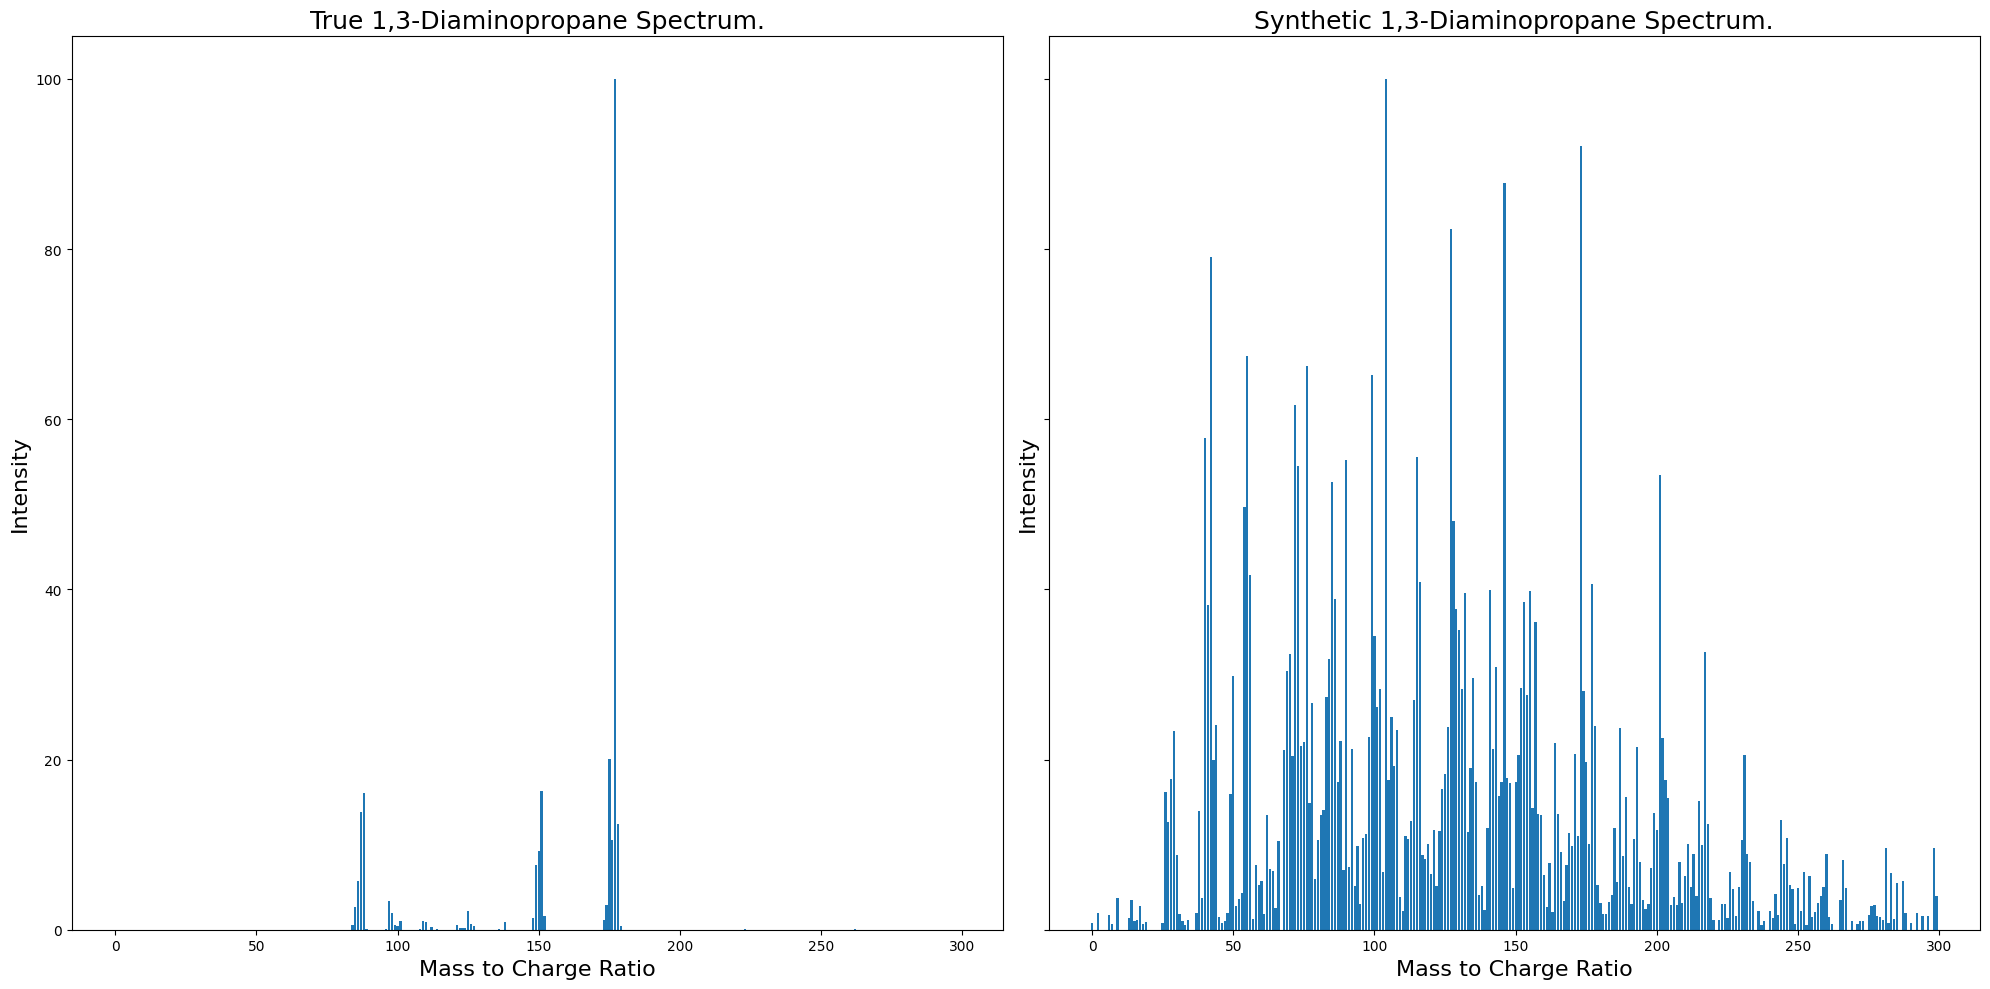

Weighted cosine similarity between true spectrum and output spectrum is:  0.3


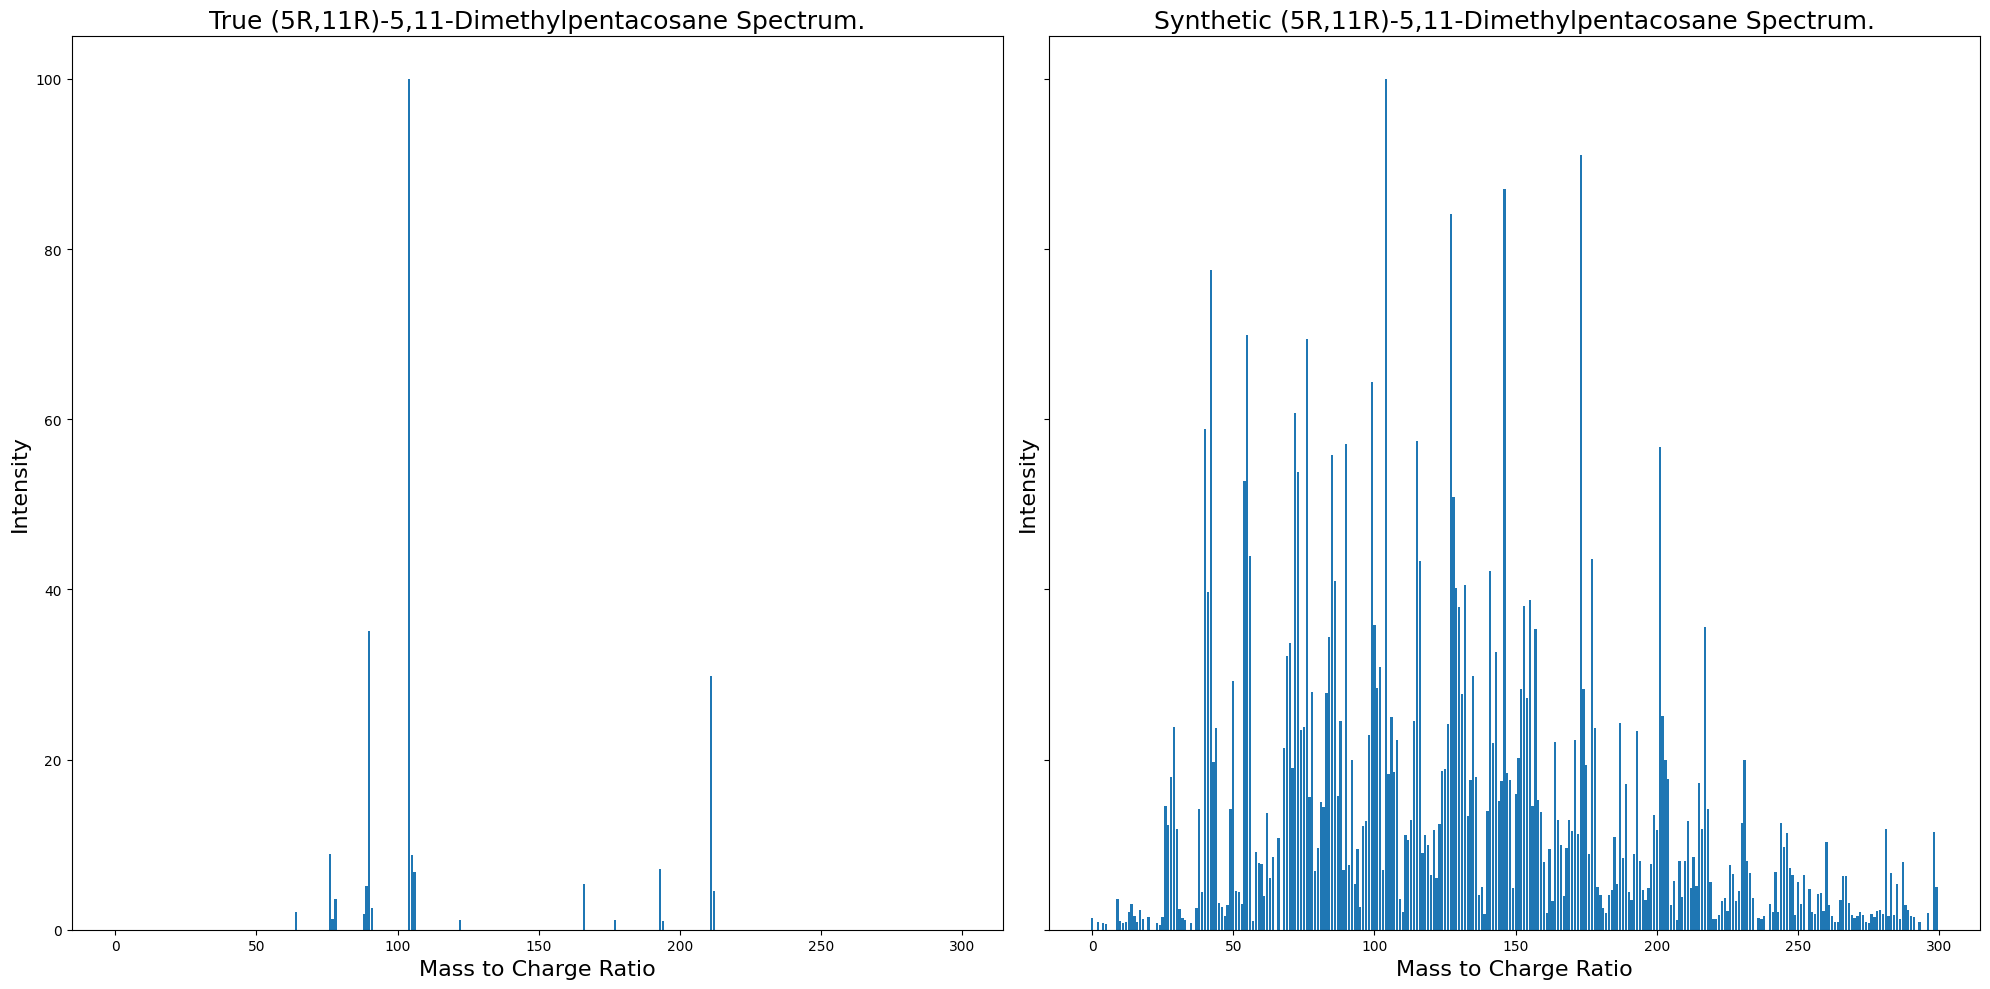

Weighted cosine similarity between true spectrum and output spectrum is:  0.18


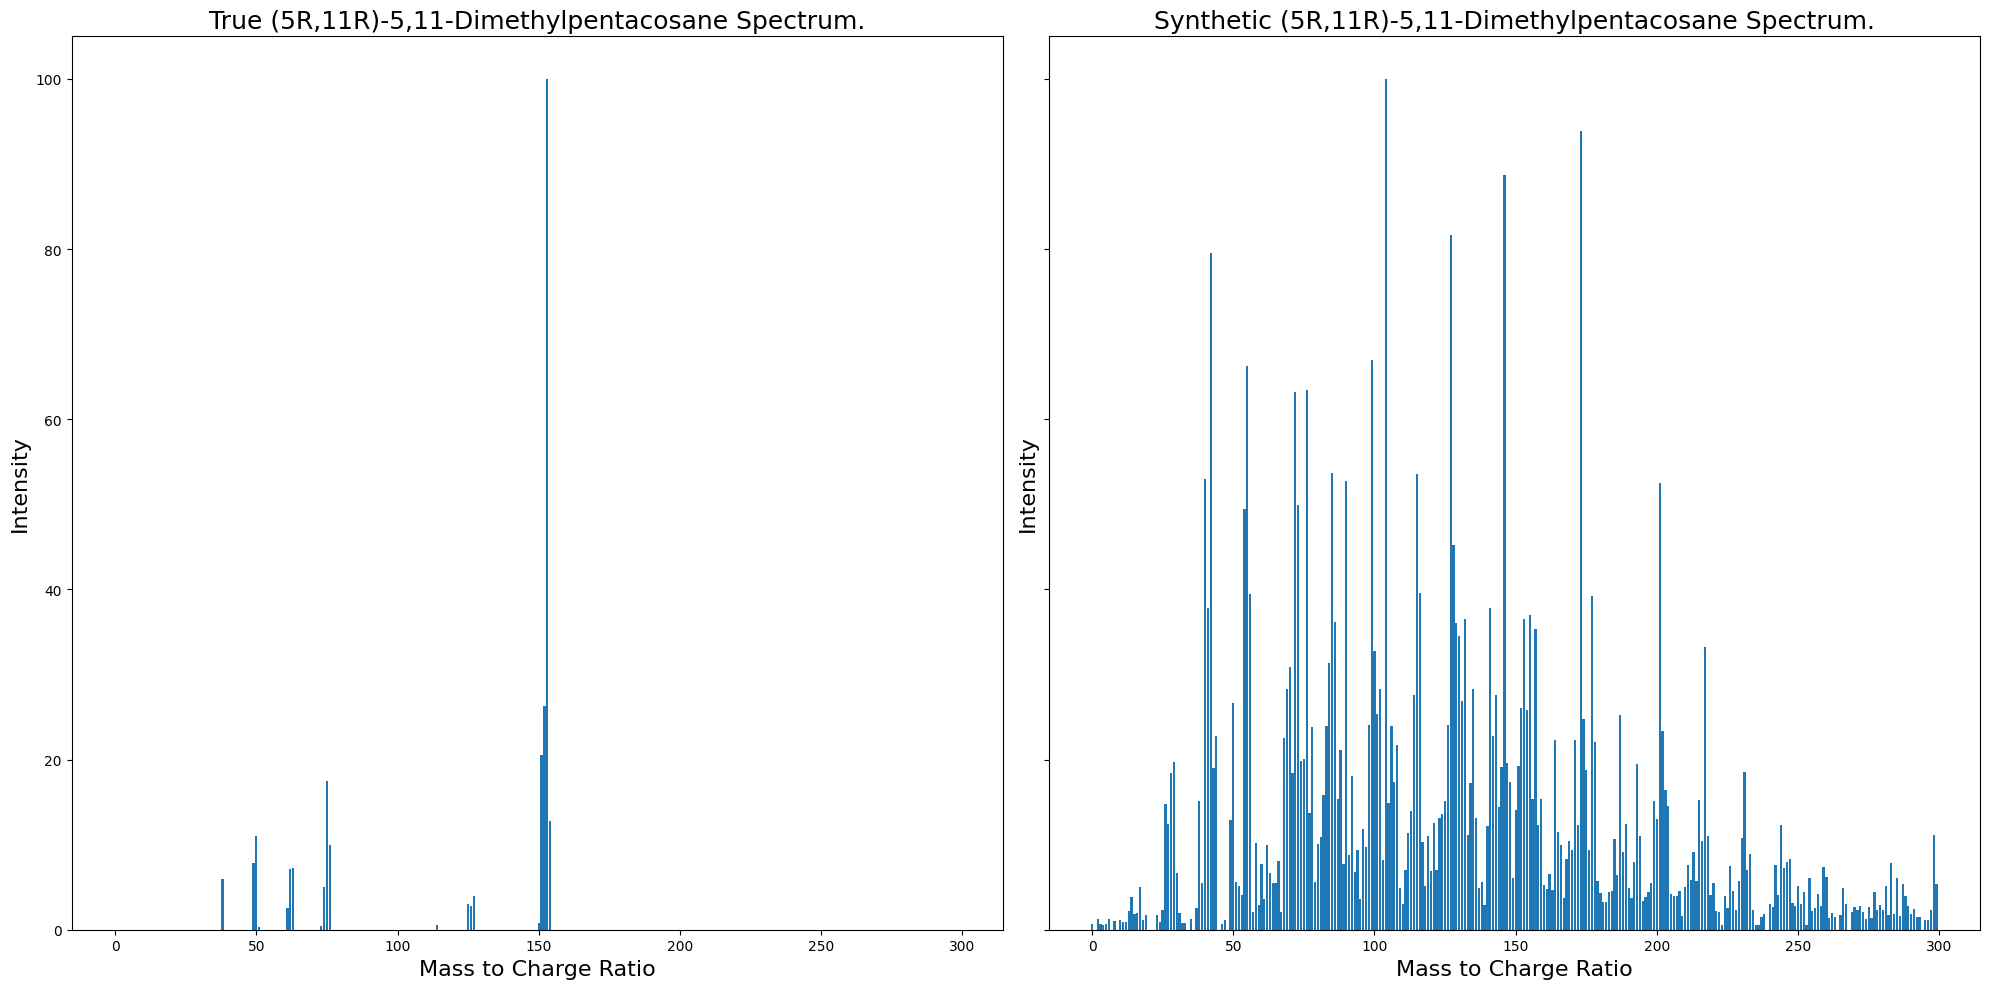

Weighted cosine similarity between true spectrum and output spectrum is:  0.25


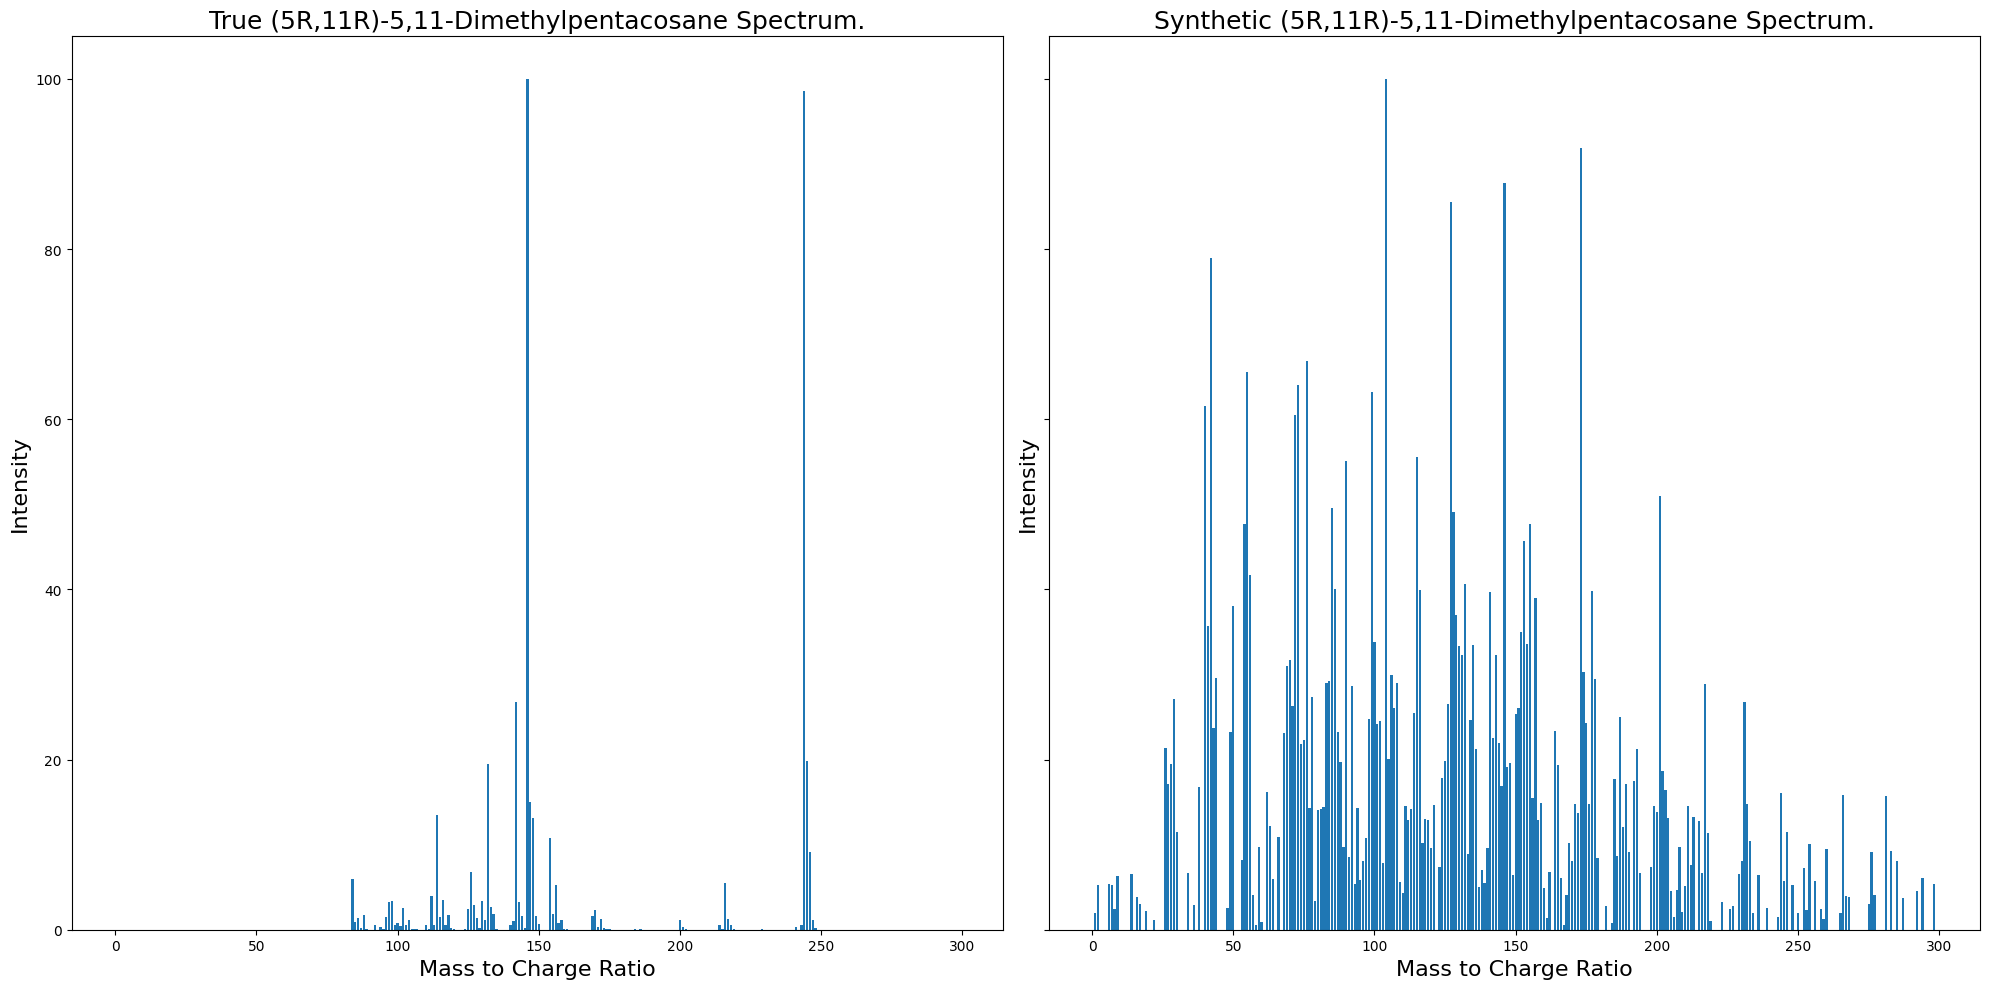

Weighted cosine similarity between true spectrum and output spectrum is:  0.29


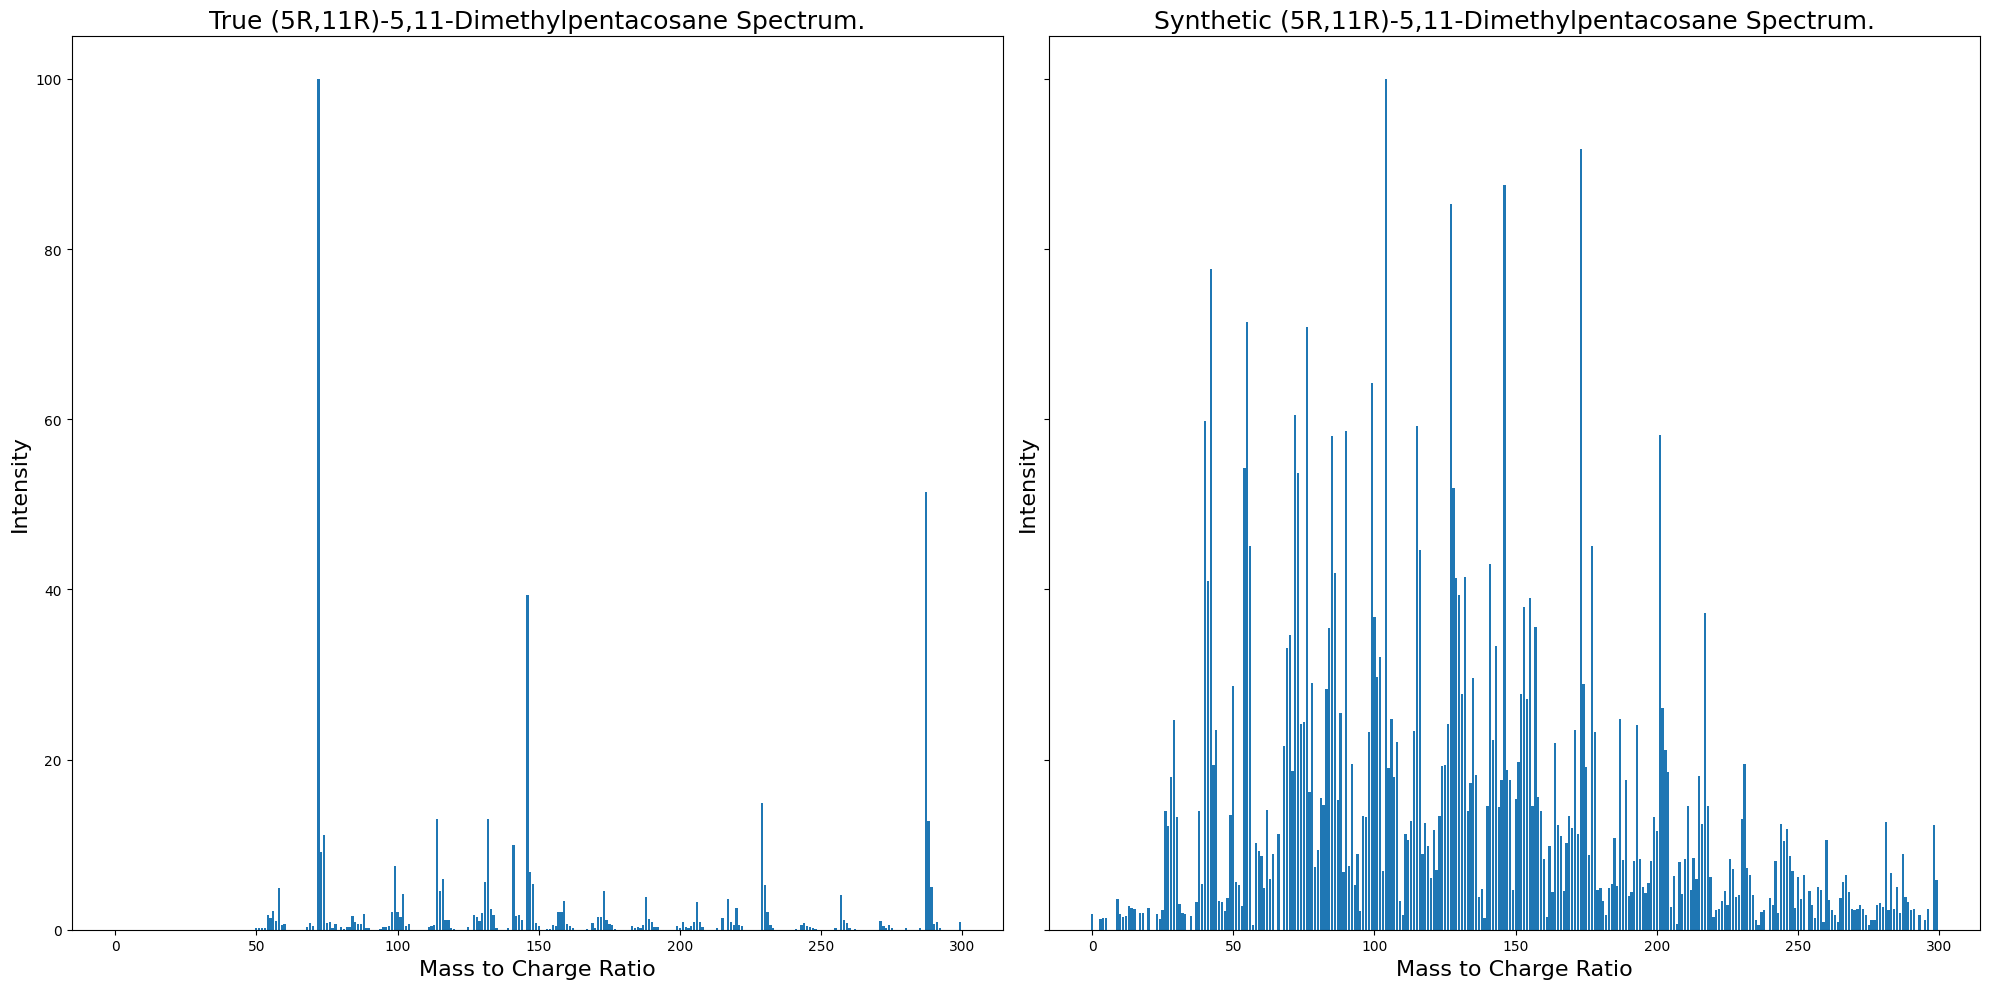

Weighted cosine similarity between true spectrum and output spectrum is:  0.33


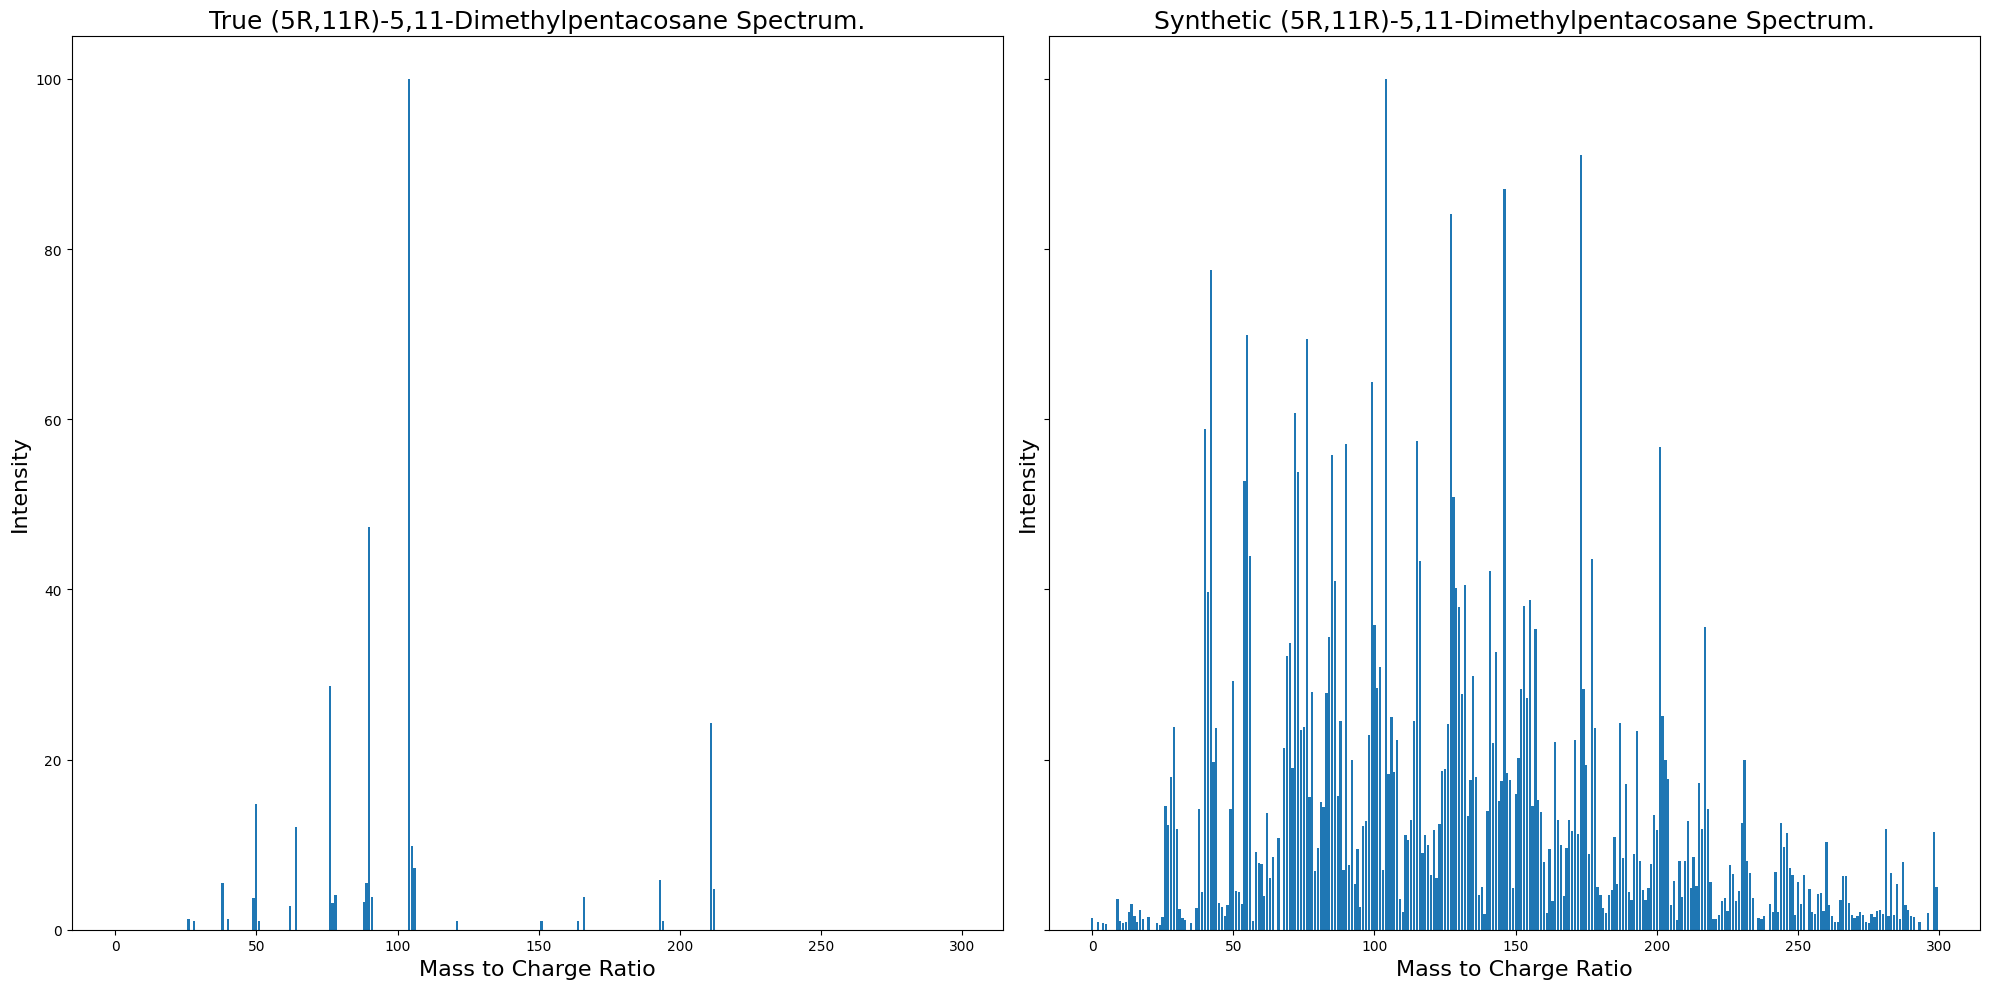

Weighted cosine similarity between true spectrum and output spectrum is:  0.22


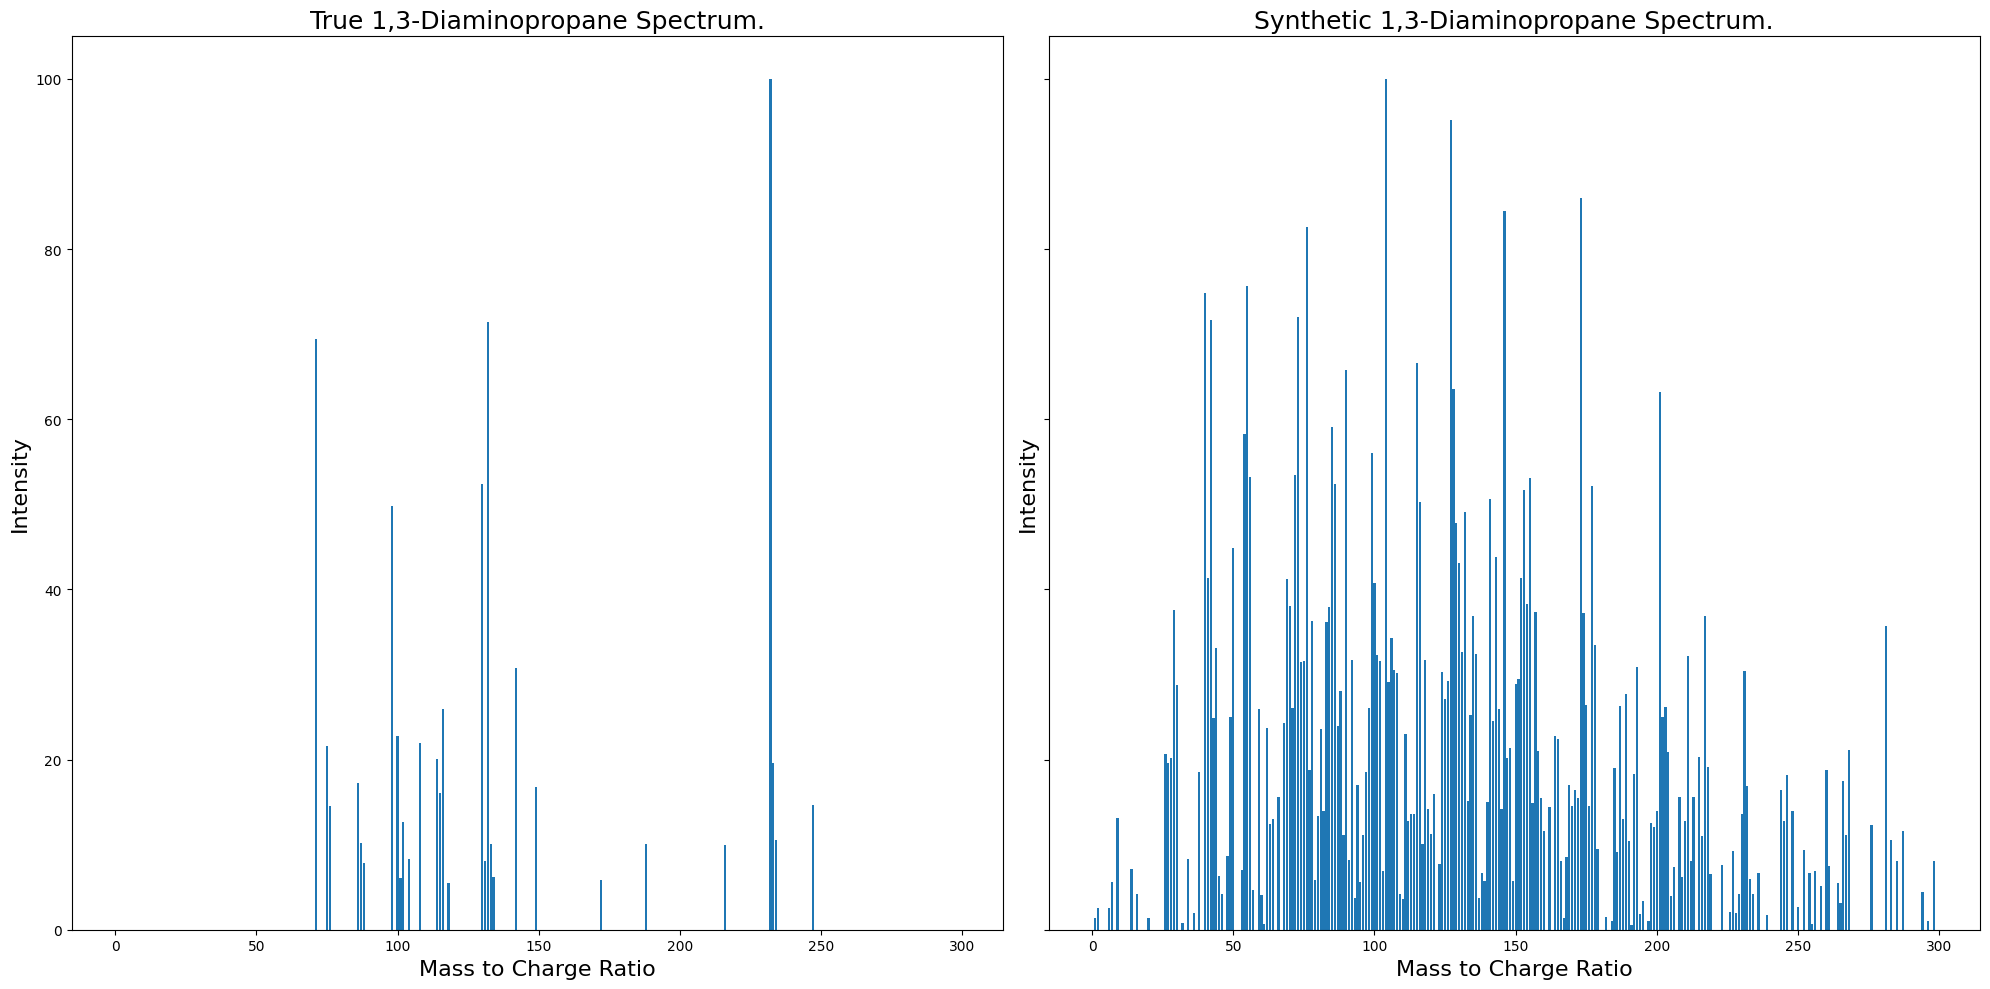

In [82]:
plotting_true_spectra = [vec[:915].detach().numpy() for vec in true_spectra]
output_spectra = [vec[:915].detach().numpy() for vec in model_output]
plot_results(plotting_true_spectra, output_spectra, output_labels)